In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
from analysis.compare_disparities import NCC, MSE, SSIM
import subprocess
import cv2
import pandas as pd
import json
import time

In [41]:
metrics_dict = {
    "SSIM": lambda x, y: SSIM(x, y, True),
    "MSE": lambda x, y: MSE(x, y, True),
    "NCC": lambda x, y: NCC(x, y)
}
datasets = next(os.walk('data'))[1]
methods = ["DP", "naive"]
lambdas = range(1, 10, 2)
w_sizes = [1, 3, 5, 7, 9]
print(f"Datasets: \t\t{datasets}")
print(f"Metrics: \t\t{list(metrics_dict.keys())}")
print(f"Methods: \t\t{methods}")
print(f"Lambdas (for DP): \t{list(lambdas)}")
print(f"Window Sizes: \t\t{w_sizes}")
padding = 30

Datasets: 		['Art', 'Reindeer', 'Laundry', 'Dolls', 'Moebius', 'Books']
Metrics: 		['SSIM', 'MSE', 'NCC']
Methods: 		['DP', 'naive']
Lambdas (for DP): 	[1, 3, 5, 7, 9]
Window Sizes: 		[1, 3, 5, 7, 9]


In [42]:
# compare metrics for different lambda for DP

times_dict_path = os.path.join("analysis", "times.json")
def read_times():
    if os.path.isfile(times_dict_path):
        with open(times_dict_path) as f:
            return json.load(f)
    else:
        return dict() 

def write_times(times_dict):
    with open(times_dict_path, 'w') as convert_file:
        convert_file.write(json.dumps(times_dict))

def run_algo(Dataset, Algo, w_size=1, l=1):
    filename = f"output"
    if Algo == "DP": filename += f"_l{l}"
    filename += f"_w{w_size}_{Algo}.png"

    file_full_name = os.path.join("output", Algo, Dataset, filename)
    output_folder = os.path.join("output", Algo, Dataset)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    times = read_times()
    time_keys = times.keys()
    if not os.path.isfile(file_full_name) or file_full_name not in time_keys:
        print(f"{file_full_name} does not exist. Computing disparity")
        command = ['./build/OpenCV_stereo',
                                        f'data/{Dataset}/view0.png', 
                                        f'data/{Dataset}/view1.png',
                                        f'output/{Algo}/{Dataset}/output',
                                        f'-l{l}', f'-w{w_size}', "-Htrue", "-ntrue", f"-m{Algo}"]
        start = time.time()
        print(f"executing command {' '.join(command)}")
        process = subprocess.Popen(command)
        stdout, stderr = process.communicate()
        end = time.time()
        execution_time = end - start
        times[file_full_name] = np.round(execution_time, 2)
        write_times(times)
    return file_full_name

def get_img_gt(Dataset):
    data_folder = os.path.join("data", Dataset)
    img_gt_path = os.path.join(data_folder, "disp1.png")
    img_gt = cv2.imread(img_gt_path, cv2.IMREAD_GRAYSCALE)
    return img_gt
    

def get_metrics_lambda(Dataset):
    Algo = "DP"
    img_gt = get_img_gt(Dataset)

    metrics = pd.DataFrame()
    for l in range(1, 10, 2):
        file_full_name = run_algo(Dataset, "DP", l=l)
        image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
        for metric_name, metric in metrics_dict.items():
            metrics.loc[l, metric_name] = metric(image[:, padding:], img_gt[:, :-padding])
    return metrics

# compare methods
def get_metrics_method(Dataset):
    img_gt = get_img_gt(Dataset)

    metrics = pd.DataFrame()

    for Algo in methods:
        l = 9
        w_size = 1 if Algo == "DP" else 9
        file_full_name = run_algo(Dataset, Algo, w_size = w_size, l=l)
        image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
        for metric_name, metric in metrics_dict.items():
            method = Algo
            if Algo == "DP": method += "(ws=1, l=9)"
            elif Algo == "naive": method += "(ws=9)"
            metrics.loc[method, metric_name] = metric(image[:, padding:], img_gt[:, :-padding])
    return metrics

# ws
def get_metrics_w_size(Dataset, Algo):
    l = 9
    img_gt = get_img_gt(Dataset)
    metrics = pd.DataFrame()
    for w_size in w_sizes:
        file_full_name = run_algo(Dataset, Algo, w_size = w_size, l=l)
        image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
        for metric_name, metric in metrics_dict.items():
            metrics.loc[w_size, metric_name] = metric(image[:, 30:], img_gt[:, :-30])
    return metrics
# ws for DP
def get_metrics_w_size_DP(Dataset):
    return get_metrics_w_size(Dataset, "DP")
# ws for naive
def get_metrics_w_size_naive(Dataset):
    return get_metrics_w_size(Dataset, "naive")

In [43]:
def get_avg_metrics(get_metrics_func):
    avg_metrics = None
    for Dataset in datasets:
        if avg_metrics is None:
            avg_metrics = get_metrics_func(Dataset)
        else:
            avg_metrics += get_metrics_func(Dataset)
    avg_metrics = avg_metrics/len(datasets)
    return avg_metrics

In [44]:
avg_metrics_lambda = get_avg_metrics(get_metrics_lambda)

Text(0.5, 1.0, 'Avg across Datasets')

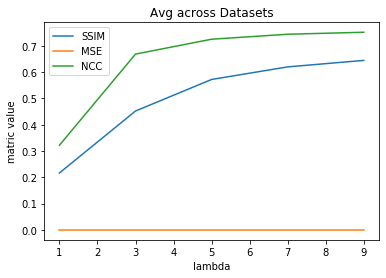

In [45]:
ax = avg_metrics_lambda.plot()
ax.set_xlabel("lambda")
ax.set_ylabel("matric value")
ax.set_title("Avg across Datasets")

In [46]:
avg_metrics_method = get_avg_metrics(get_metrics_method)

Text(0, 0.5, 'matric value')

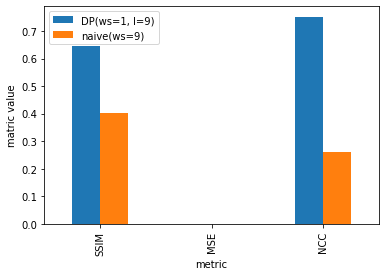

In [47]:
ax = avg_metrics_method.T.plot.bar()
ax.set_xlabel("metric")
ax.set_ylabel("matric value")

In [48]:
metrics_w_size_naive_avg = get_avg_metrics(get_metrics_w_size_naive)

In [49]:
metrics_w_size_DP_avg = get_avg_metrics(get_metrics_w_size_DP)

Text(0.5, 1.0, 'Avg across Datasets (DP, l=9.0)')

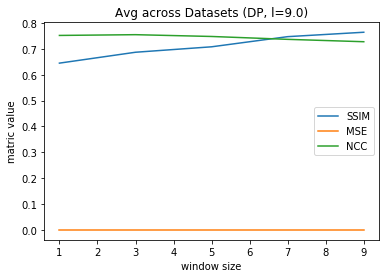

In [50]:
ax = metrics_w_size_DP_avg.plot()
ax.set_xlabel("window size")
ax.set_ylabel("metric value")
ax.set_title("Avg across Datasets (DP, l=9.0)")

Text(0.5, 1.0, 'Avg across Datasets (naive)')

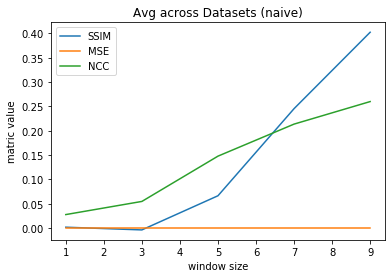

In [51]:
ax = metrics_w_size_naive_avg.plot()
ax.set_xlabel("window size")
ax.set_ylabel("matric value")
ax.set_title("Avg across Datasets (naive)")

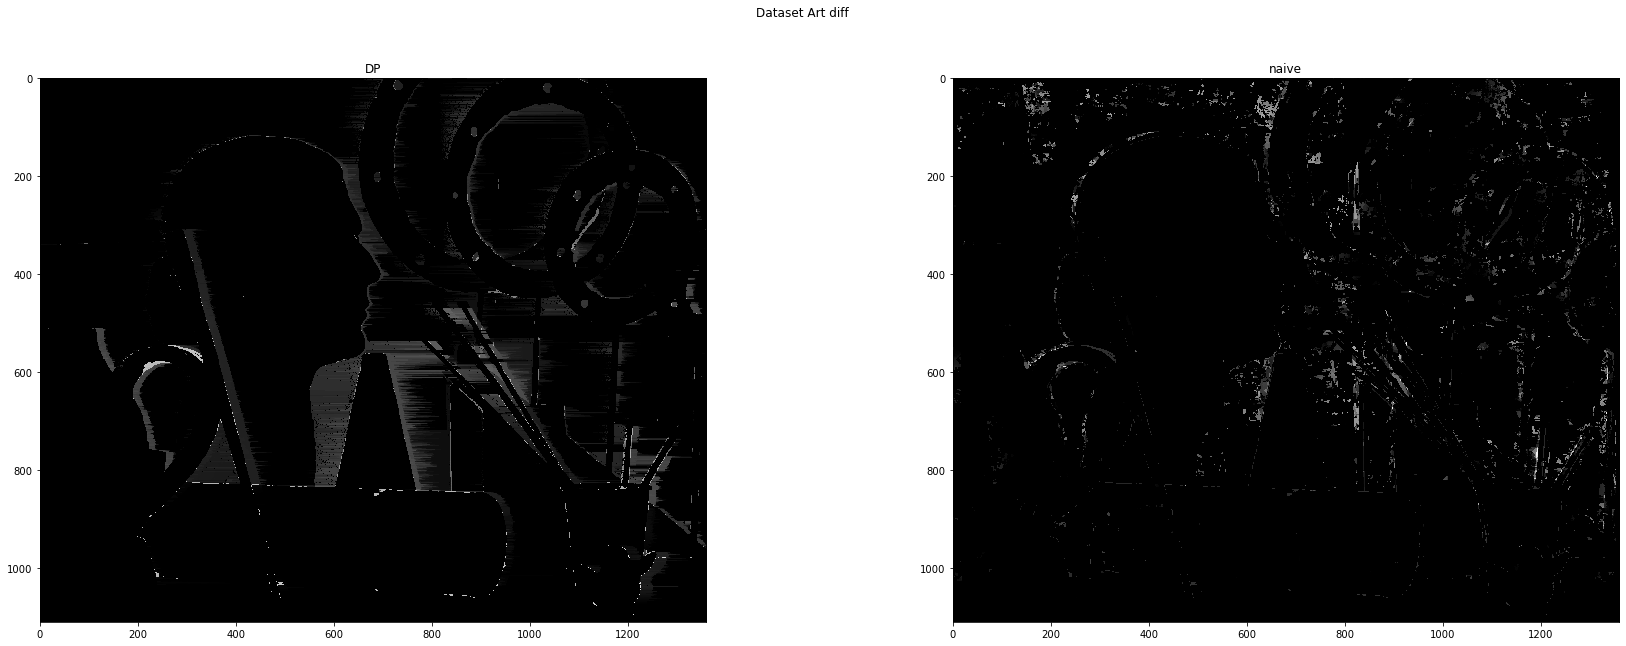

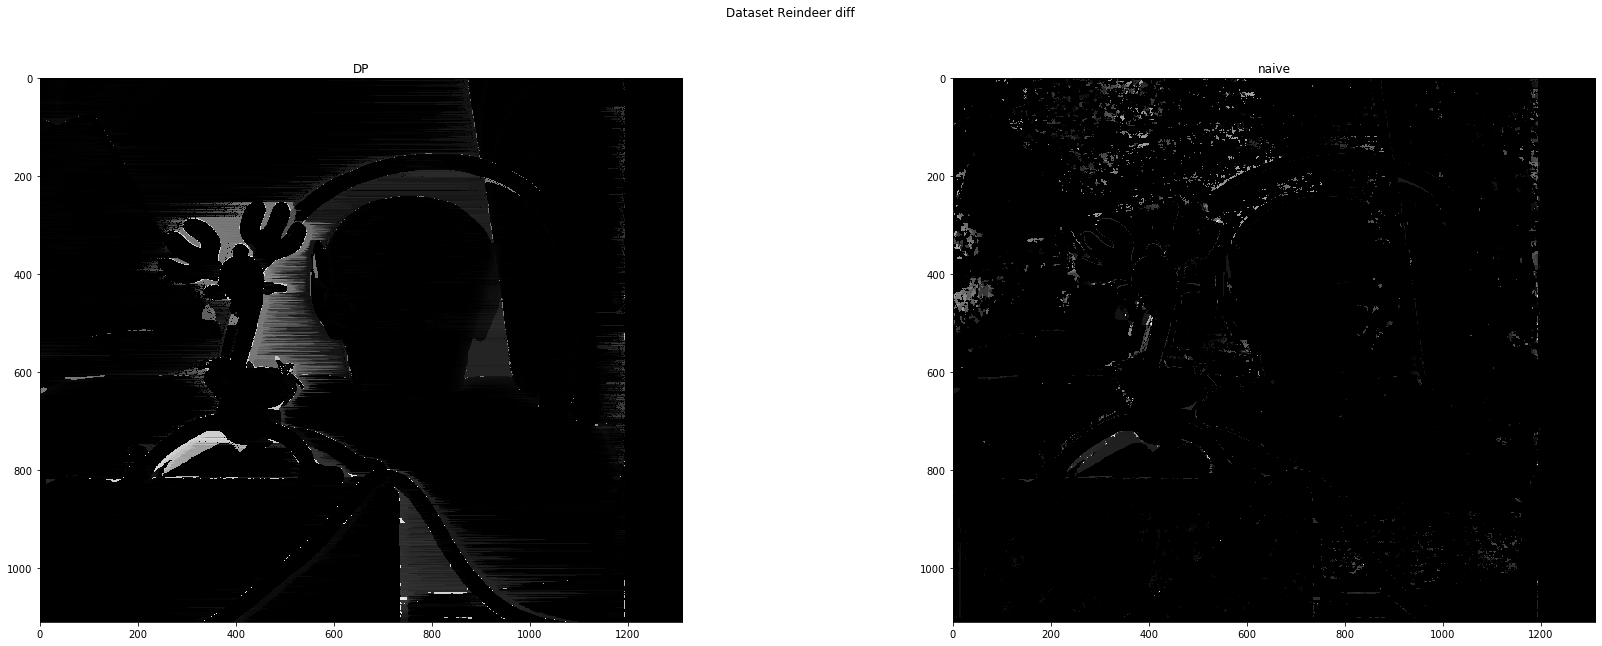

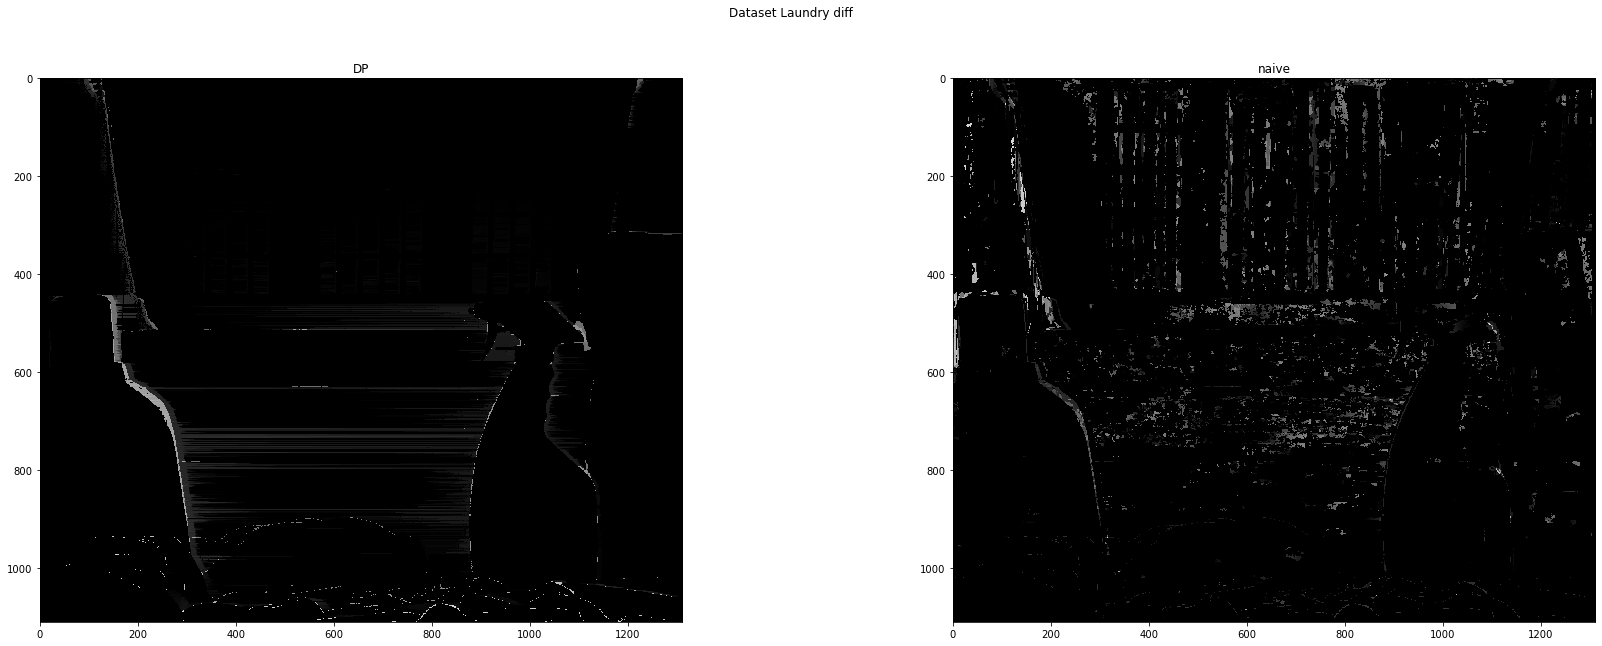

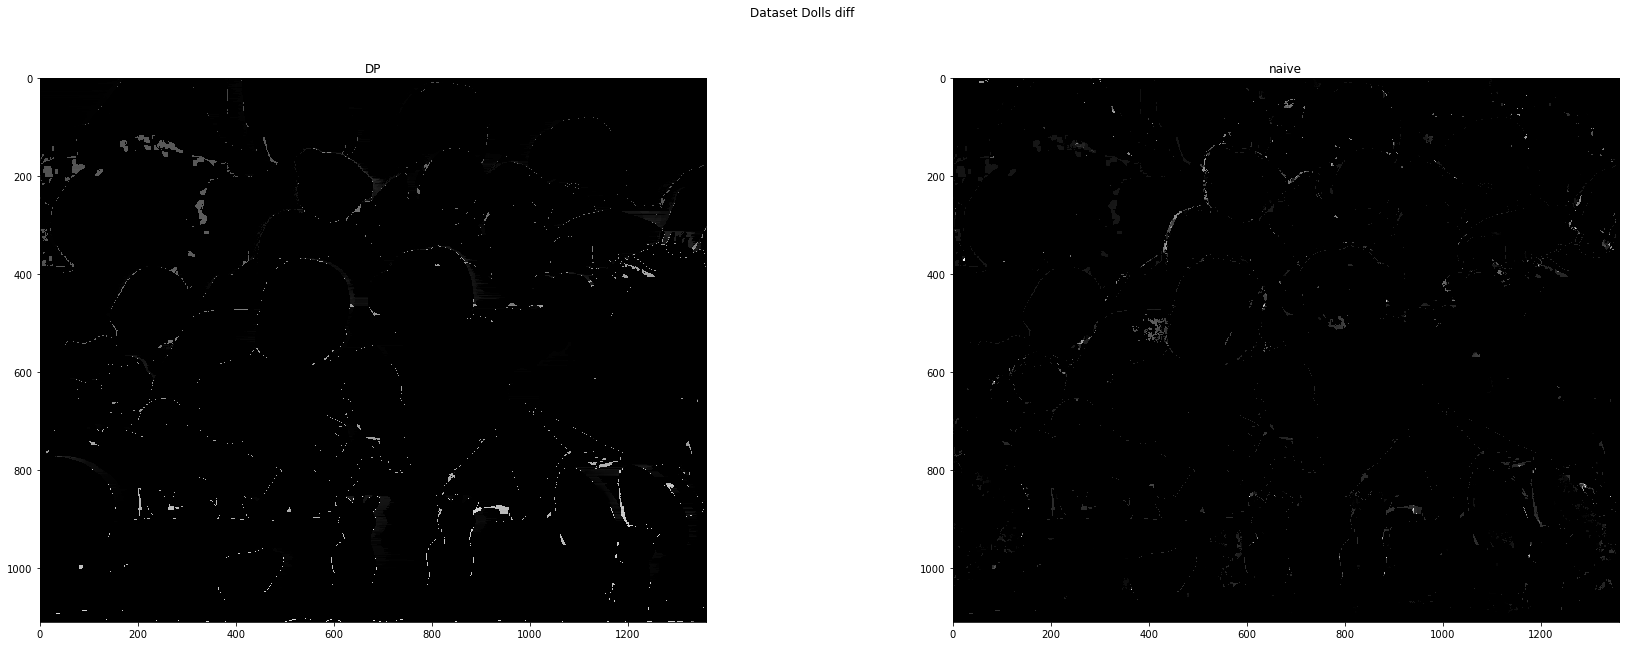

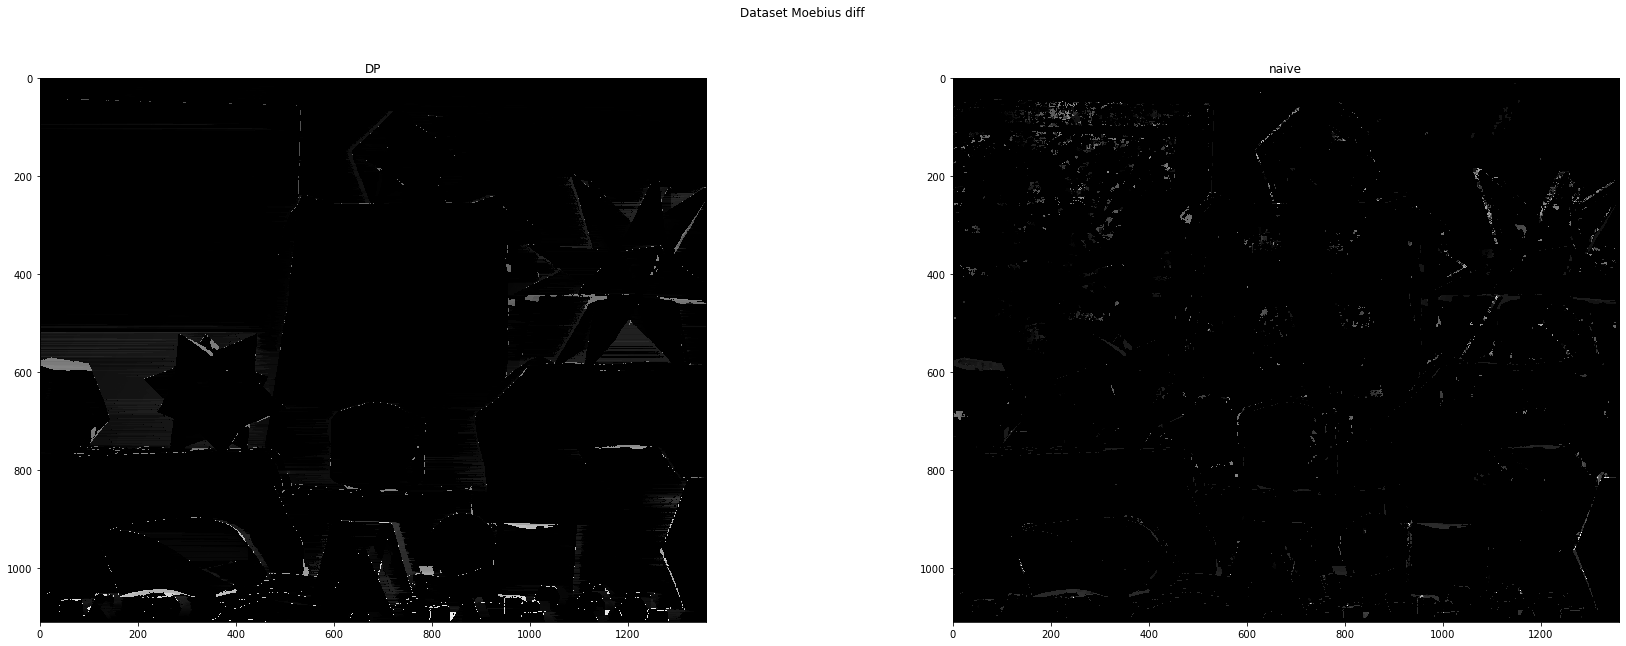

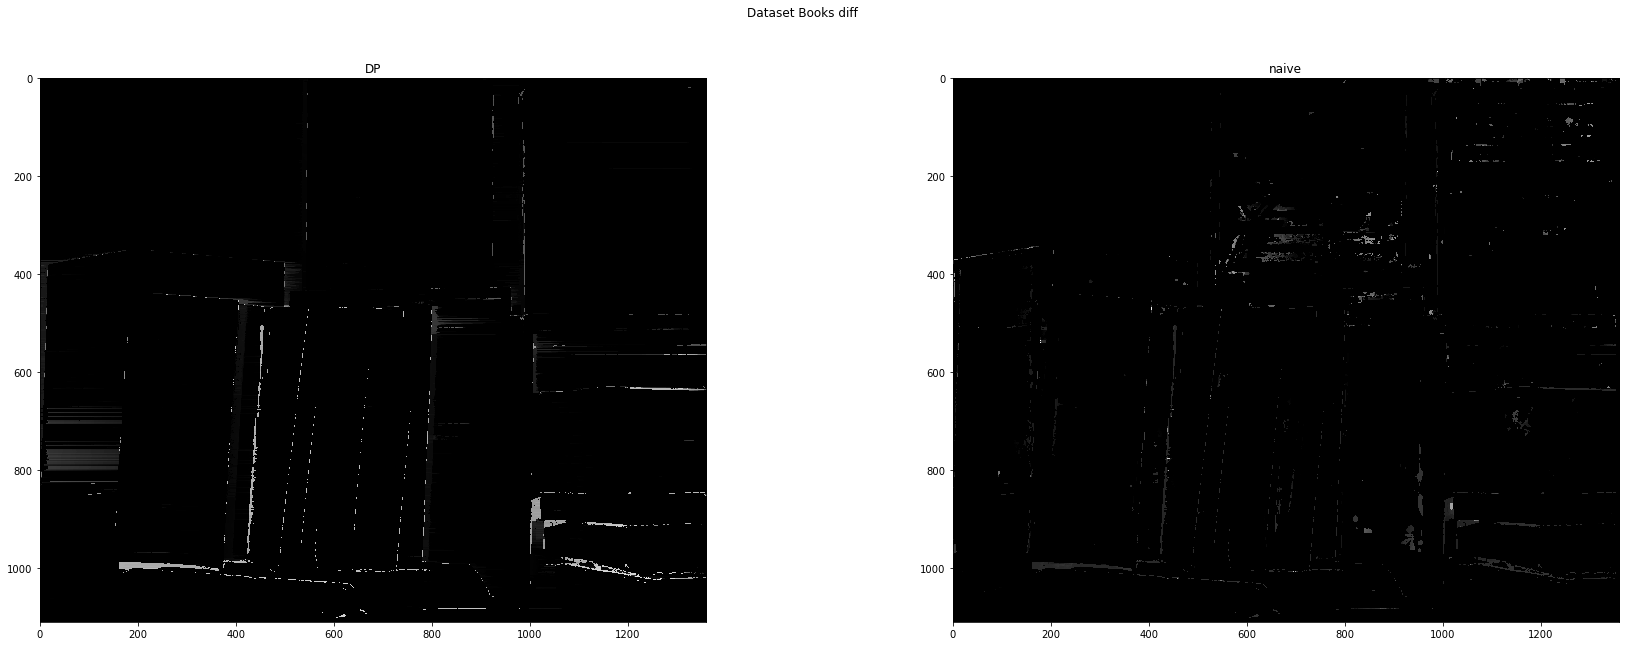

In [78]:

# diff images
Dataset = "Art"
for Dataset in datasets:
    f, ax = plt.subplots(1, len(methods))
    f.set_figheight(10)
    f.set_figwidth(30)
    for i, Algo in enumerate(methods):
        l = 9

        w = 1 if Algo == "DP" else 9
        img_gt = get_img_gt(Dataset)
        gt_normed = cv2.normalize(img_gt, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        
        file_full_name = run_algo(Dataset, Algo, w, l)

        output_folder = os.path.join("output", Algo, Dataset)
        file_full_name = run_algo(Dataset, Algo, w, l)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        image = cv2.imread(file_full_name, cv2.IMREAD_GRAYSCALE)
        orig_normed = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) 
        image_diff = orig_normed[:, padding:] - gt_normed[:, :-padding]
        ax[i].imshow(image_diff * 255,cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(Algo)
    plt.suptitle(f"Dataset {Dataset} diff")
    plt.show()

In [53]:
# processing times

In [93]:
def get_execution_time(Dataset = None, Algo=None, w_s=None, l=None):
    times = read_times()
    times = {key[:-4]: value for key, value in times.items()}
    if Algo is not None: times = {key: value for key, value in times.items() if key.split("/")[1] == Algo}
    if Dataset is not None: times = {key: value for key, value in times.items() if key.split("/")[2] == Dataset}
    if w_s is not None: times = {key: value for key, value in times.items() if key.split("_")[-2] == f"w{int(w_s)}"}
    if Algo == "DP" and l is not None:
        times = {key: value for key, value in times.items() if key.split("_")[1] == f"l{int(l)}"}
    return times

In [105]:
def get_time_method_ws(Dataset):
    exec_times_ws = pd.DataFrame()
    for Algo in methods:
        for ws in w_sizes:
            e_time = list(get_execution_time(Algo=Algo, Dataset=Dataset, w_s=ws, l=9.0).values())[0]
            exec_times_ws.loc[ws, Algo] = e_time
    return exec_times_ws

In [116]:
exec_times_ws = get_avg_metrics(get_time_method_ws)

Text(0.5, 1.0, 'Avg execution time')

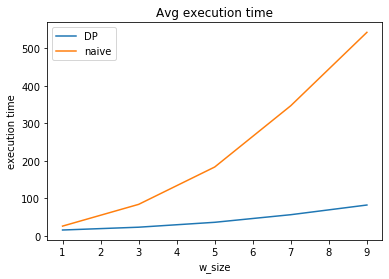

In [112]:
ax = exec_times_ws.plot()
ax.set_xlabel("w_size")
ax.set_ylabel("execution time")
ax.set_title("Avg execution time")

In [113]:
def get_time_method_lambda(Dataset):
    exec_times_ws = pd.DataFrame()
    for l in lambdas:
        for ws in w_sizes:
            e_time = list(get_execution_time(Algo="DP", Dataset=Dataset, w_s=1, l=l).values())[0]
            exec_times_ws.loc[ws, Algo] = e_time
    return exec_times_ws

In [115]:
exec_times_l = get_avg_metrics(get_time_method_lambda)

Text(0.5, 1.0, 'Avg execution time')

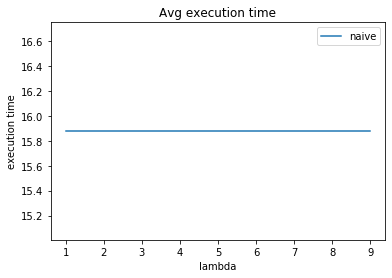

In [117]:
ax = exec_times_l.plot()
ax.set_xlabel("lambda")
ax.set_ylabel("execution time")
ax.set_title("Avg execution time")